In [2]:
%matplotlib inline
# Scientific computing
import numpy as np

# Data frames (R-style)
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning packages
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Read data
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
test_y = pd.read_csv('./data/gender_submission.csv').Survived

train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,NaN,C


In [4]:
train_data.info()
print("--------------")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB
--------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417

We hebben dus 891 entries. De meeste data lijkt compleet, maar bij leeftijd missen er een aantal waardes. Voor test is dit hetzelfde, maar mist er ook een fare waarde.

In [5]:
grouped = train_data.groupby('Survived')
grouped.count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


Als we de data groeperen op onze doel-variabele, zien we dat de klassen redelijk gebalanceerd zijn.

We hebben dus redelijk gebalanceerde aantallen over de doel-variabele en de data is ook vrij goed (weinig missende getallen).

Wel hebben we een aantal categoriën die minder zeggen (naam, id, kaartnummer, waar ze ingestapt zijn). Deze variabelen kunnen we uit de set gooien.

Daarna moeten we de NAN's in de age kolom nog aanpakken. 

We gaan er hier even van uit dat dit hetzelfde is voor de test data.

In [6]:
train_data.drop(['PassengerId','Name','Ticket','Cabin','Embarked'], axis=1, inplace=True)
train_data['Age'].fillna(train_data['Age'].mean(), inplace=True)
train_data.Age = train_data.Age.round(decimals=0)
train_data.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22,1,0,7.2500
1,1,1,female,38,1,0,71.2833
2,1,3,female,26,0,0,7.9250
3,1,1,female,35,1,0,53.1000
4,0,3,male,35,0,0,8.0500
5,0,3,male,30,0,0,8.4583
6,0,1,male,54,0,0,51.8625
7,0,3,male,2,3,1,21.0750
8,1,3,female,27,0,2,11.1333
9,1,2,female,14,1,0,30.0708


In [7]:
test_data.drop(['PassengerId','Name','Ticket','Cabin','Embarked'], axis=1, inplace=True)
test_data['Age'].fillna(test_data['Age'].mean(), inplace=True)
test_data.Age = test_data.Age.round(decimals=0)
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 6 columns):
Pclass    418 non-null int64
Sex       418 non-null object
Age       418 non-null float64
SibSp     418 non-null int64
Parch     418 non-null int64
Fare      418 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 22.9+ KB


Als laatste voorbereiding maken we van een aantal variablen categorische variabelen.

In [8]:
#train_data.Pclass = train_data.Pclass.astype('category')
#train_data.Sex = train_data.Sex.astype('category')
train_data['Sex'] = np.where(train_data['Sex'] == 'female', 1, 0)

#test_data.Pclass = test_data.Pclass.astype('category')
#test_data.Sex = test_data.Sex.astype('category')
test_data['Sex'] = np.where(test_data['Sex'] == 'female', 1, 0)
test_data.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,0,34,0,0,7.8292
1,3,1,47,1,0,7.0000
2,2,0,62,0,0,9.6875
3,3,0,27,0,0,8.6625
4,3,1,22,1,1,12.2875
5,3,0,14,0,0,9.2250
6,3,1,30,0,0,7.6292
7,2,0,26,1,1,29.0000
8,3,1,18,0,0,7.2292
9,3,0,21,2,0,24.1500


Nu kunnen we gaan kijken naar de data

Survived    1.000000
Pclass     -0.338481
Sex         0.543351
Age        -0.070324
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Name: Survived, dtype: float64


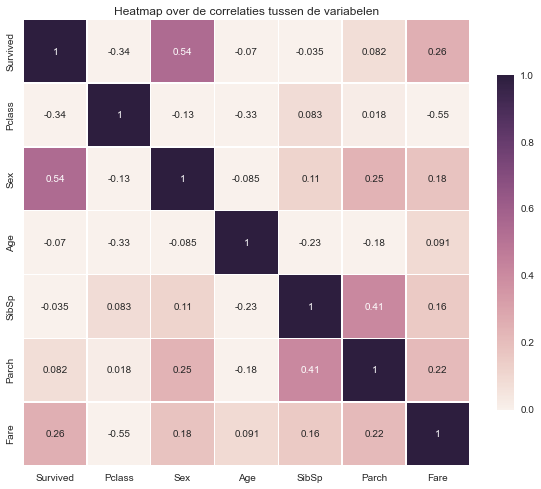

In [9]:
correlations = train_data.corr()
print(correlations['Survived'])

plt.figure(figsize=(10,10))
sns.heatmap(correlations,linewidths=0.25, square=True, cbar_kws={'shrink' : .6}, annot=True, vmin=0, vmax=1)
plt.title("Heatmap over de correlaties tussen de variabelen")

Het lijkt er op dat er niet veel variabelen zijn die sterk met elkaar gecorreleerd zijn. Hier hoeven we dus niet veel voorwerk te doen.

Laten we als laatste eens kijken naar hoe de variabelen onderling verdeeld zijn. 

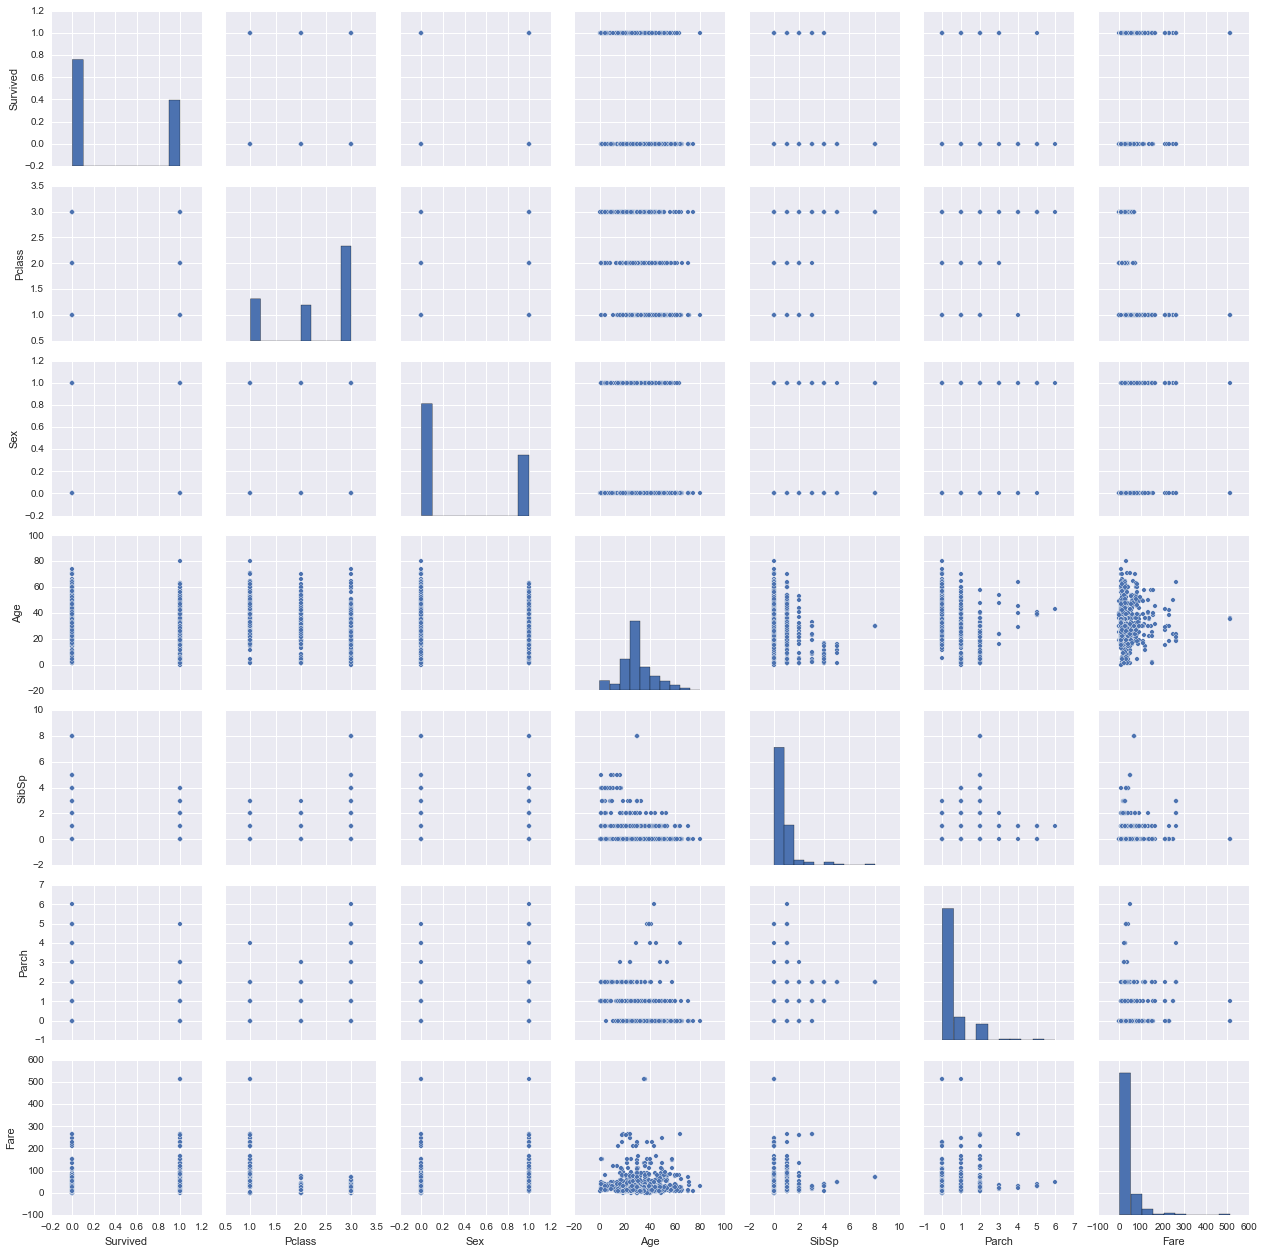

In [10]:
sns.pairplot(train_data)

In [11]:
# Train the model 
train_x = train_data.drop('Survived', axis=1, inplace=False)
train_y = train_data.Survived

classifier = tree.DecisionTreeClassifier()
classifier.fit(train_x, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [26]:
# Check score on training set
cm_train = confusion_matrix(train_y, classifier.predict(train_x))
auc_train = roc_auc_score(train_y, classifier.predict(train_x))
f1_train = f1_score(train_y, classifier.predict(train_x))
print(cm_train)
print('------------------------------')
print('AUC      : {}'.format(auc_train))
print('F1 Score : {}'.format(f1_train))

[[546   3]
 [ 16 326]]
------------------------------
AUC      : 0.9738759466973445
F1 Score : 0.9716840536512668


In [15]:
# Create predictions on the test set
predictions = classifier.predict(test_data)

In [27]:
# Score on the test outcomes
cm_test = confusion_matrix(test_y, predictions)
f1_test = f1_score(test_y, predictions)
auc_test = roc_auc_score(test_y, predictions)
print(cm_test)
print('------------------------------')
print('AUC      : {}'.format(auc_test))
print('F1 Score : {}'.format(f1_test))

[[225  41]
 [ 35 117]]
------------------------------
AUC      : 0.8078007518796992
F1 Score : 0.7548387096774193


In [19]:
# Save decision tree to file, reload it and show in a plot
#with open("dt.dot", 'w') as f:
#    export_graphviz(classifier, out_file=f,
#                    feature_names=list(train_x))
#
#    pydot.graph_from_dot_data(dotfile.getvalue()).write_png(file_path)
#    i = misc.imread(file_path)
#    plt.imshow(i)

There seems to be a lot of overfitting. Perhaps we can tweak the model to have some more constraints.

In [20]:
# Look at our current tree
classifier.get_params

<bound method DecisionTreeClassifier.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')>

In [21]:
c2 = tree.DecisionTreeClassifier(max_depth = 15, max_leaf_nodes=10)
c2.fit(train_x, train_y)

f1_score(train_y, c2.predict(train_x))

0.76609105180533754

We not have a highly constrained decision tree. A much lower score on the train set means we're not fitting to all our training examples anymore. 

Lets see if this helps our test predictions any

In [28]:
pred = c2.predict(test_data)
print(confusion_matrix(test_y, pred))
print("------------------------------")
print("AUC Score = {}".format(roc_auc_score(test_y, pred)))
print("F1 Score  = {}".format(f1_score(test_y, pred)))

[[260   6]
 [ 12 140]]
-----------------------------
AUC Score = 0.9492481203007519
F1 Score  = 0.9395973154362416


We get a much better score with our constrained tree. Overfitting indeed was the problem.

Finally lets try a Random Forest to see if a whole set of (constrained) decision trees does better then a single tree.

In [29]:
forest = RandomForestClassifier(n_estimators=100, max_leaf_nodes=10)
forest.fit(train_x, train_y)
y_pred = forest.predict(test_data)
print("Accuracy score = {}".format(forest.score(test_data, test_y)))
print("F1 score       = {}".format(f1_score(test_y, y_pred)))
print("AUC score      = {}".format(roc_auc_score(test_y,y_pred)))
print("---------")
print(confusion_matrix(test_y, y_pred))

Accuracy score = 0.930622009569378
F1 score       = 0.9010238907849829
AUC score      = 0.9172932330827068
---------
[[257   9]
 [ 20 132]]
